In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from datetime import timedelta
from collections import Counter
#from warnings import filterwarnings
#filterwarnings('ignore')

In [2]:
data = pd.read_csv('clv_es_2014_v2.dsv', sep=';', low_memory=False)

In [3]:
len(data)

2406773

In [4]:
%run -i cleaning_n_formatting.py 

Duplicated rows detected:  1281
Start dropping..
Number of order IDs having more than one SP_START_DATE now:  0


In [5]:
len(data)

2405492

In [6]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_SALES_CANCEL_BMF', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID',
       'SCM_AS_ID', 'SCM_MASTER_AP_ID', 'SCM_IS_ZSP_ORDER',
       'SCM_C_ORDER_STATUS', 'CTP_N_KEY_CUSTOMER_TYPE', 'SCM_OCI_LAND',
       'SCM_D_FC_ID', 'SCM_D_PC_DSP', 'SCM_FC_SPLIT',
       'CAM_N_KEY_CUST_ACQ_CAMPAIGN', 'SCM_IS_SINGLE_CATEGORY', 'O_ZAHLUNGSA',
       'O_ORIGIN', 'OSP_KO_COUNT', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORF_EXT_O_ID', 'ORF_EXT_K_ID', 'ORF_EXT_ROOT_K_ID',
       'OP_AS_ID', 'OP_BONUSPOINTS', 'BP_TYP', 'ORDER_DATETIME', 'WEEK_NUMBER',
       'MONTH_NUMBER', 'FINANCE_ORDER_NET', 'REL_CM1', 'REL_CM2'],

In [7]:
data['CZP_ZTQ_ID'] = data['CZP_ZTQ_ID'].fillna(0)
#data['CZP_START_DATE'] = data['CZP_START_DATE'].fillna(0)
#data['CZP_EXPIRY_DATE'] = data['CZP_EXPIRY_DATE'].fillna(0)

In [8]:
data['TDT_T_KEY_ORDER_DATE'].min(), data['TDT_T_KEY_ORDER_DATE'].max()

(Timestamp('2013-11-22 00:00:00'), Timestamp('2018-06-29 00:00:00'))

In [9]:
data['ORF_EXT_ROOT_K_ID'].nunique(), data['CUS_N_KEY_CUSTOMER'].nunique()

(84414, 89921)

In [16]:
data.head()[data.columns[:20]]

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_SALES_CANCEL_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,SCM_AP_ID,SCM_AS_ID,SCM_MASTER_AP_ID,SCM_IS_ZSP_ORDER,SCM_C_ORDER_STATUS,CTP_N_KEY_CUSTOMER_TYPE,SCM_OCI_LAND,SCM_D_FC_ID,SCM_D_PC_DSP
0,437335499,102533713,2018-01-15,01:45,15,10616357,36.99,0.0,9.3073,2.7569,33.6273,61155,2152388,61155,0,L,0,E2,324,116
1,437335500,102533713,2018-01-15,01:45,15,10616357,29.99,0.0,11.5851,9.8985,24.7851,7753,1234957,7753,0,L,0,E2,324,116
2,437335501,102533713,2018-01-15,01:45,15,10616357,-3.35,0.0,-2.9215,-2.9215,-2.9215,0,6,42715,0,L,0,E2,0,0
3,437332929,102533283,2018-01-15,00:50,15,9689285,9.99,0.0,3.1162,0.7703,8.2562,54297,1003834,54297,0,L,0,E2,324,116
4,437332930,102533283,2018-01-15,00:50,15,9689285,16.99,0.0,7.4413,1.8177,14.0413,27330,470509,27330,0,L,0,E2,324,116


In [86]:
sp_customers = pd.DataFrame(columns=['ORF_EXT_ROOT_K_ID', 'ACQ_CAMP', 'PAY_METH', 'ORIGIN', 'TIER', 'ORDERS', 'SALES',
                                     'NET_SALES', 'BASKET_AVG', 'CM1', 'CM1_AVG', 'CM1%', 'CM2', 'CM2_AVG', 'CM2%', 
                                     'CUS_LEAD_PG3', 'IMPORTANCE_PG3', 'CUS_LEAD_PG4', 'IMPORTANCE_PG4',
                                     'SP_SD', 'SP_ED', 'SP_DIFF', 'SP_QTY', 'FIRST_O_DATE', 'LAST_O_DATE', 'O_DIFF',
                                     'MON_PUR_FREQ_30D', 'MON_PUR_FREQ_60D', 'MON_PUR_FREQ_90D',
                                     'MON_PUR_FREQ_180D', 'MON_PUR_FREQ_360D', 'MON_PUR_FREQ_540D', 'MON_PUR_FREQ_720D'])

for n, cus in enumerate(data['ORF_EXT_ROOT_K_ID'].unique()):
    cus_data = data[data['ORF_EXT_ROOT_K_ID'] == cus]
    camp = cus_data['CAM_N_KEY_CUST_ACQ_CAMPAIGN'].unique()
    pay_meth = cus_data['O_ZAHLUNGSA'].unique()
    origin = cus_data['O_ORIGIN'].unique()
    tier = cus_data['CZP_ZTQ_ID'].unique()
    orders = cus_data['SCM_N_ORDER_NR'].nunique()
    sales = cus_data['SCM_SALES_BMF'].sum() - cus_data['SCM_SALES_CANCEL_BMF'].sum() 
    net_sales = cus_data['SCM_D_ORIG_FINANCE_ORDER_NET'].sum()
    basket_avg = sales / orders
    cm1 = cus_data['SCM_D_FINANCE_CM1'].sum()
    cm1_avg = cm1 / orders
    cm1_perc = cm1 / net_sales * 100
    #neg_cm1_orders = len(cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum()\
    #[cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum() < 0].index.values)
    #perc_neg_cm1_orders = neg_cm1_orders / orders * 100
    #total_loss_cm1 = cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum()\
    #                [cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum() < 0].sum()
    cm2 = cus_data['SCM_D_FINANCE_CM2'].sum()
    cm2_avg = cm2 / orders
    cm2_perc = cm2 / net_sales * 100
    #neg_cm2_orders = len(cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum()\
    #[cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum() < 0].index.values)
    #perc_neg_cm2_orders = neg_cm2_orders / orders * 100
    #total_loss_cm2 = cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum()\
    #                [cus_data.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum() < 0].sum()
    if (cus_data['CZP_START_DATE'].astype(str) == 'NaT').all():
        sp_start_date = 0
        sp_expiry_date = 0
        sp_diff_days = 0
        sp_qty = 0
    else:
        sp_start_date = cus_data['CZP_START_DATE'].min()
        sp_expiry_date = cus_data['CZP_EXPIRY_DATE'].max()
        sp_diff = sp_expiry_date - sp_start_date
        sp_diff_days = sp_diff.days
        sp_qty = cus_data['CZP_EXPIRY_DATE'].nunique()
    first_o_date = cus_data['TDT_T_KEY_ORDER_DATE'].dt.date.min()
    last_o_date = cus_data['TDT_T_KEY_ORDER_DATE'].dt.date.max()
    diff_date = (last_o_date - first_o_date)
    
    pg3_series = [i[0] for i in data[data['ORF_EXT_ROOT_K_ID'] == cus].groupby('SCM_N_ORDER_NR')\
                  ['OSP_3_LEAD_P_PG_ID'].unique().values]
    cntr = Counter(pg3_series)
    cus_lead_pg3 = cntr.most_common()[0][0]
    importance_pg3 = cntr.most_common()[0][1] / orders
    
    pg4_series = [i[0] for i in data[data['ORF_EXT_ROOT_K_ID'] == cus].groupby('SCM_N_ORDER_NR')\
                  ['OSP_4_LEAD_P_PG_ID'].unique().values]
    cnter = Counter(pg4_series)
    cus_lead_pg4 = cnter.most_common()[0][0]
    importance_pg4 = cnter.most_common()[0][1] / orders
    
    mon_freq_30d = first_o_date + timedelta(days = 30)
    ord_30d = cus_data[(cus_data['TDT_T_KEY_ORDER_DATE'] >= first_o_date) & 
             (cus_data['TDT_T_KEY_ORDER_DATE'] <= mon_freq_30d)]['SCM_N_ORDER_NR'].nunique()
    pur_freq_mon_30d = ord_30d
    mon_freq_60d = first_o_date + timedelta(days = 60)
    ord_60d = cus_data[(cus_data['TDT_T_KEY_ORDER_DATE'] >= first_o_date) & 
             (cus_data['TDT_T_KEY_ORDER_DATE'] <= mon_freq_60d)]['SCM_N_ORDER_NR'].nunique()
    pur_freq_mon_60d = ord_60d / 2
    mon_freq_90d = first_o_date + timedelta(days = 90)
    ord_90d = cus_data[(cus_data['TDT_T_KEY_ORDER_DATE'] >= first_o_date) & 
             (cus_data['TDT_T_KEY_ORDER_DATE'] <= mon_freq_90d)]['SCM_N_ORDER_NR'].nunique()
    pur_freq_mon_90d = ord_90d / 3
    mon_freq_180d = first_o_date + timedelta(days = 180)
    ord_180d = cus_data[(cus_data['TDT_T_KEY_ORDER_DATE'] >= first_o_date) & 
             (cus_data['TDT_T_KEY_ORDER_DATE'] <= mon_freq_180d)]['SCM_N_ORDER_NR'].nunique()
    pur_freq_mon_180d = ord_180d / 6
    mon_freq_360d = first_o_date + timedelta(days = 360)
    ord_360d = cus_data[(cus_data['TDT_T_KEY_ORDER_DATE'] >= first_o_date) & 
             (cus_data['TDT_T_KEY_ORDER_DATE'] <= mon_freq_360d)]['SCM_N_ORDER_NR'].nunique()
    pur_freq_mon_360d = ord_360d / 12
    mon_freq_540d = first_o_date + timedelta(days = 540)
    ord_540d = cus_data[(cus_data['TDT_T_KEY_ORDER_DATE'] >= first_o_date) & 
             (cus_data['TDT_T_KEY_ORDER_DATE'] <= mon_freq_540d)]['SCM_N_ORDER_NR'].nunique()
    pur_freq_mon_540d = ord_540d / 18
    mon_freq_720d = first_o_date + timedelta(days = 720)
    ord_720d = cus_data[(cus_data['TDT_T_KEY_ORDER_DATE'] >= first_o_date) & 
             (cus_data['TDT_T_KEY_ORDER_DATE'] <= mon_freq_720d)]['SCM_N_ORDER_NR'].nunique()
    pur_freq_mon_720d = ord_720d / 24
    
    row_ = [cus, camp, pay_meth, origin, tier, orders, sales, net_sales, basket_avg, cm1, cm1_avg, cm1_perc,
            cm2, cm2_avg, cm2_perc, cus_lead_pg3, importance_pg3, cus_lead_pg4, importance_pg4,
            sp_start_date, sp_expiry_date, sp_diff, sp_qty,
            first_o_date, last_o_date, diff_date.days, pur_freq_mon_30d, pur_freq_mon_60d, 
            pur_freq_mon_90d, pur_freq_mon_180d, pur_freq_mon_360d, pur_freq_mon_540d, pur_freq_mon_720d]
    row_ = pd.DataFrame([row_], columns=sp_customers.columns)
    sp_customers = pd.concat([sp_customers, row_], ignore_index=True)
    
    if n % 5000 == 0:
        print(n)

0


cleaning_n_formatting.py:20: RuntimeWarning: invalid value encountered in double_scalars
  data['SCM_SALES_CANCEL_BMF'] = lista1
cleaning_n_formatting.py:28: RuntimeWarning: invalid value encountered in double_scalars
  #Convert date to calendar week number and month number
cleaning_n_formatting.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  data['SCM_SALES_CANCEL_BMF'] = lista1
cleaning_n_formatting.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  #Convert date to calendar week number and month number


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000


In [87]:
sp_customers.round(2).sample(10)[sp_customers.columns[20:]]

,SP_ED,SP_DIFF,SP_QTY,FIRST_O_DATE,LAST_O_DATE,O_DIFF,MON_PUR_FREQ_30D,MON_PUR_FREQ_60D,MON_PUR_FREQ_90D,MON_PUR_FREQ_180D,MON_PUR_FREQ_360D,MON_PUR_FREQ_540D,MON_PUR_FREQ_720D
35933,0,731 days,0,2014-09-17,2016-08-31,714,1,1.0,1.00,0.67,0.50,0.33,0.29
66141,0,365 days,0,2014-08-30,2014-08-30,0,1,0.5,0.33,0.17,0.08,0.06,0.04
976,2017-05-05 00:00:00,1096 days,1,2014-01-28,2014-07-02,155,1,1.0,1.00,1.00,0.50,0.33,0.25
50446,0,1454 days,0,2014-10-25,2015-11-26,397,1,0.5,0.33,0.33,0.17,0.17,0.12
83267,0,365 days,0,2014-12-30,2014-12-30,0,1,0.5,0.33,0.17,0.08,0.06,0.04
51069,0,365 days,0,2014-11-08,2014-11-08,0,1,0.5,0.33,0.17,0.08,0.06,0.04
59309,0,365 days,0,2014-12-31,2014-12-31,0,1,0.5,0.33,0.17,0.08,0.06,0.04
73913,0,365 days,0,2014-05-28,2014-05-28,0,1,0.5,0.33,0.17,0.08,0.06,0.04
16051,2019-05-29 00:00:00,822 days,2,2014-08-14,2018-05-29,1384,1,1.0,0.67,0.67,0.67,0.61,0.54
31856,0,762 days,0,2014-10-03,2018-04-30,1305,2,1.0,0.67,0.33,0.17,0.11,0.08


In [88]:
sp_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84414 entries, 0 to 84413
Data columns (total 33 columns):
ORF_EXT_ROOT_K_ID    84414 non-null object
ACQ_CAMP             84414 non-null object
PAY_METH             84414 non-null object
ORIGIN               84414 non-null object
TIER                 84414 non-null object
ORDERS               84414 non-null object
SALES                84414 non-null float64
NET_SALES            84414 non-null float64
BASKET_AVG           84414 non-null float64
CM1                  84414 non-null float64
CM1_AVG              84414 non-null float64
CM1%                 84390 non-null float64
CM2                  84414 non-null float64
CM2_AVG              84414 non-null float64
CM2%                 84390 non-null float64
CUS_LEAD_PG3         84414 non-null object
IMPORTANCE_PG3       84414 non-null float64
CUS_LEAD_PG4         84414 non-null object
IMPORTANCE_PG4       84414 non-null float64
SP_SD                84414 non-null object
SP_ED               

In [89]:
days = [i.days for i in sp_customers['SP_DIFF']]

In [90]:
len(days)

84414

In [91]:
sp_customers['SP_DIFF'] = days

In [92]:
sp_customers.round(2).to_csv('clv_es_customers_starting_in_2014.csv', sep=';', index=False, encoding='utf-8')

In [93]:
customers = pd.read_csv('clv_es_customers_starting_in_2014.csv', sep=';', low_memory=False)

In [94]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84414 entries, 0 to 84413
Data columns (total 33 columns):
ORF_EXT_ROOT_K_ID    84414 non-null int64
ACQ_CAMP             84414 non-null object
PAY_METH             84414 non-null object
ORIGIN               84414 non-null object
TIER                 84414 non-null object
ORDERS               84414 non-null int64
SALES                84414 non-null float64
NET_SALES            84414 non-null float64
BASKET_AVG           84414 non-null float64
CM1                  84414 non-null float64
CM1_AVG              84414 non-null float64
CM1%                 84390 non-null float64
CM2                  84414 non-null float64
CM2_AVG              84414 non-null float64
CM2%                 84390 non-null float64
CUS_LEAD_PG3         84414 non-null int64
IMPORTANCE_PG3       84414 non-null float64
CUS_LEAD_PG4         84414 non-null int64
IMPORTANCE_PG4       84414 non-null float64
SP_SD                84414 non-null object
SP_ED                844

In [95]:
customers.head()[customers.columns[15:]]

,CUS_LEAD_PG3,IMPORTANCE_PG3,CUS_LEAD_PG4,IMPORTANCE_PG4,SP_SD,SP_ED,SP_DIFF,SP_QTY,FIRST_O_DATE,LAST_O_DATE,O_DIFF,MON_PUR_FREQ_30D,MON_PUR_FREQ_60D,MON_PUR_FREQ_90D,MON_PUR_FREQ_180D,MON_PUR_FREQ_360D,MON_PUR_FREQ_540D,MON_PUR_FREQ_720D
0,251,1.00,17798,1.00,2015-04-01 00:00:00,2019-05-29 00:00:00,1519,2,2014-12-03,2018-03-26,1209,1,0.5,0.33,0.33,0.33,0.28,0.29
1,2068,0.48,3155,0.27,2014-12-06 00:00:00,2020-12-06 00:00:00,2192,4,2014-07-08,2018-06-15,1438,2,1.0,1.00,2.00,2.58,2.50,2.25
2,251,0.93,682,0.91,0,0,2192,0,2014-10-25,2018-06-28,1342,2,1.5,1.33,1.00,1.08,1.39,1.54
3,2190,0.50,10618,0.50,0,0,2192,0,2014-09-15,2018-01-08,1211,1,0.5,0.33,0.17,0.08,0.06,0.04
4,252,0.42,71918,0.29,0,0,2192,0,2014-07-16,2018-06-12,1427,1,0.5,0.67,0.67,0.50,0.50,0.46


In [96]:
#customers['SP_SD'] = pd.to_datetime(customers['SP_SD'], format='%Y-%m-%d')
#customers['SP_ED'] = pd.to_datetime(customers['SP_ED'], format='%Y-%m-%d')
customers['FIRST_O_DATE'] = pd.to_datetime(customers['FIRST_O_DATE'], format='%Y-%m-%d')
customers['LAST_O_DATE'] = pd.to_datetime(customers['LAST_O_DATE'], format='%Y-%m-%d')

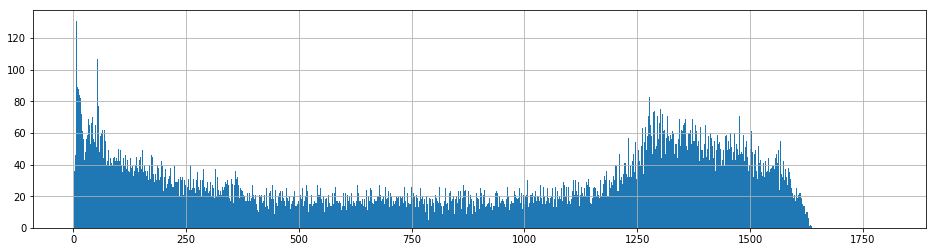

In [97]:
plt.figure(figsize=(16, 4))
customers['O_DIFF'].hist(bins=1800, range=(1, 1800))

In [98]:
customers['PAY_METH'].value_counts().head(10)

['K']         38977
['PP']        18563
['CD']         6326
['K' 'R']      3667
['R']          2907
['K' 'PP']     2857
['PP' 'K']     2629
['R' 'K']      1218
['K' 'CD']     1099
['PP' 'R']     1035
Name: PAY_METH, dtype: int64

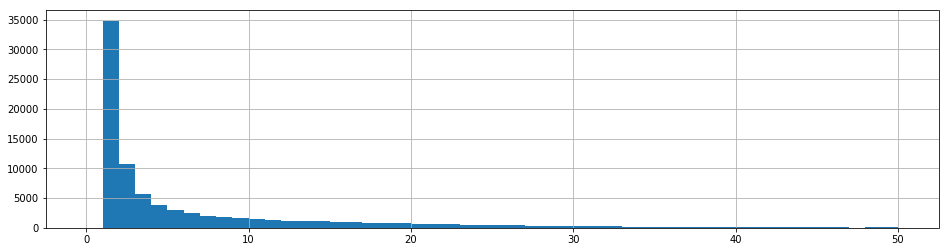

In [99]:
plt.figure(figsize=(16, 4))
customers['ORDERS'].hist(bins=50, range=(0, 50))

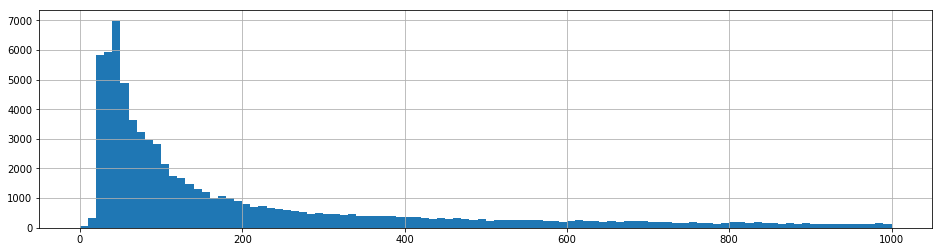

In [100]:
plt.figure(figsize=(16, 4))
customers['SALES'].hist(bins=100, range=(0, 1000))

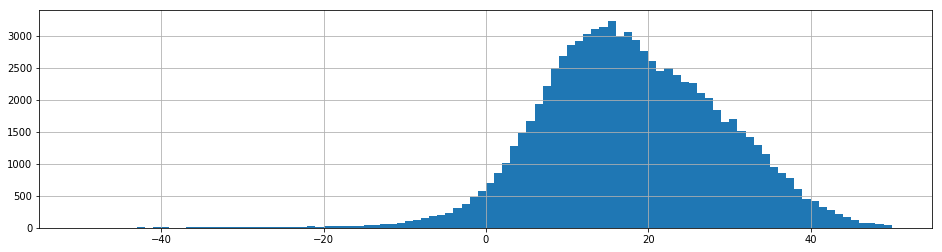

In [101]:
plt.figure(figsize=(16, 4))
customers['CM2%'].hist(bins=100, range=(-50, 50))

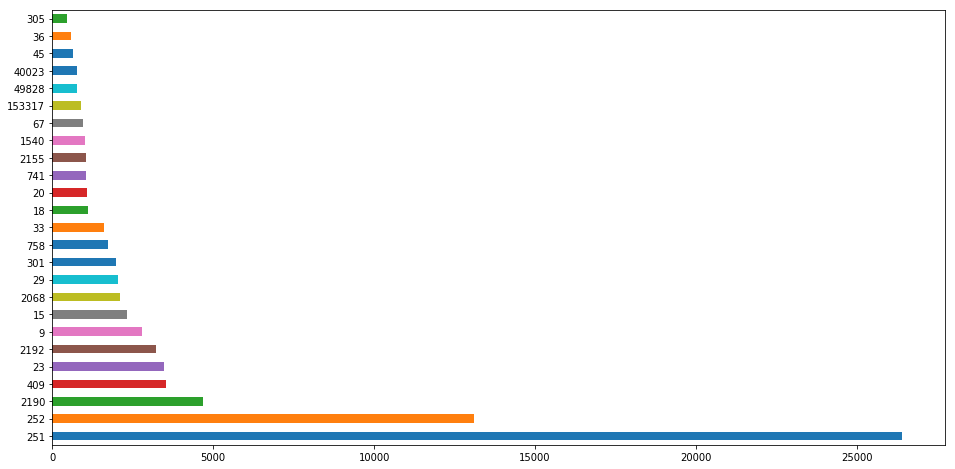

In [102]:
plt.figure(figsize=(16, 8))
customers['CUS_LEAD_PG3'].value_counts().head(25).plot(kind='barh')

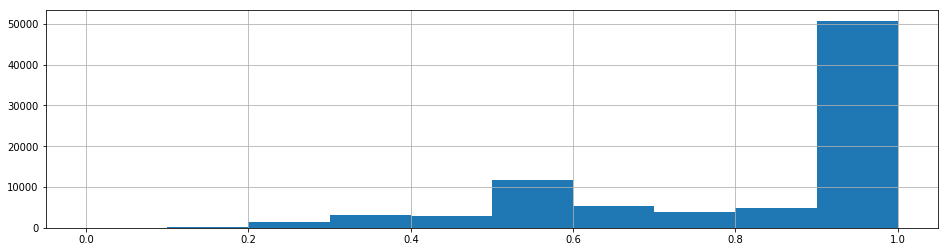

In [103]:
plt.figure(figsize=(16, 4))
customers['IMPORTANCE_PG3'].hist(bins=10, range=(0, 1))

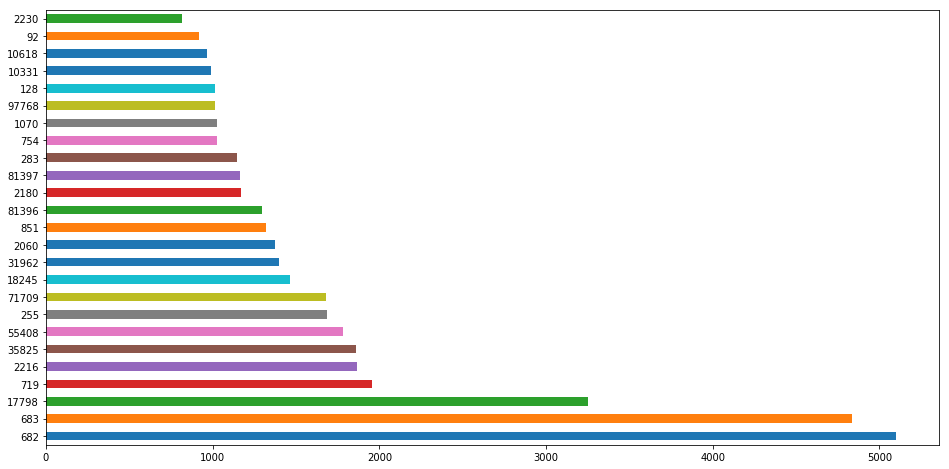

In [104]:
plt.figure(figsize=(16, 8))
customers['CUS_LEAD_PG4'].value_counts().head(25).plot(kind='barh')